Теоретические вопросы:

1) Расскажите, как работает регуляризация в решающих деревьях, какие параметры мы штрафуем в данных алгоритмах?

Штрафы назначаются за излюшнюю сложность дерева. 

2) По какому принципу рассчитывается "важность признака (feature_importance)" в ансамблях деревьев?

По приросту информации от использования признака. Чем большее уменьшение точности предсказания влечёт
за собой исключение признака, тем выше важность признака.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/geekbrains/test.csv
/kaggle/input/geekbrains/sample_submission.csv
/kaggle/input/geekbrains/train.csv


In [2]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#### Функции из уроков:

In [3]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
    def balance_df_by_target(df, target_name):
        target_counts = df[target_name].value_counts()

        major_class_name = target_counts.argmax()
        minor_class_name = target_counts.argmin()

        disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
        
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

        return df.sample(frac=1) 
    
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

##### Собственные функции

In [4]:
def is_data_correct(df):
    return [df.median(), df.max(), df.min(), df.isna().sum()]

def new_num_features(df, old_name):
    names = dict()
    i = 0
    for j in list(df[old_name].unique()):
        names[j] = i
        i += 1
    df[old_name + '_num'] = df[old_name].map(names)
    return df
    #return names

### Построение базового решения

In [5]:
# ../input/forcompetition/test.csv
# ../input/forcompetition/train.csv

df_train = pd.read_csv('../input/geekbrains/train.csv')
df_test = pd.read_csv('../input/geekbrains/test.csv')

#### Просмотр данных

In [6]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

In [8]:
df_train.isna().sum(), df_test.isna().sum()

(Home Ownership                     0
 Annual Income                   1557
 Years in current job             371
 Tax Liens                          0
 Number of Open Accounts            0
 Years of Credit History            0
 Maximum Open Credit                0
 Number of Credit Problems          0
 Months since last delinquent    4081
 Bankruptcies                      14
 Purpose                            0
 Term                               0
 Current Loan Amount                0
 Current Credit Balance             0
 Monthly Debt                       0
 Credit Score                    1557
 Credit Default                     0
 dtype: int64,
 Home Ownership                     0
 Annual Income                    513
 Years in current job              86
 Tax Liens                          0
 Number of Open Accounts            0
 Years of Credit History            0
 Maximum Open Credit                0
 Number of Credit Problems          0
 Months since last delinquent    13

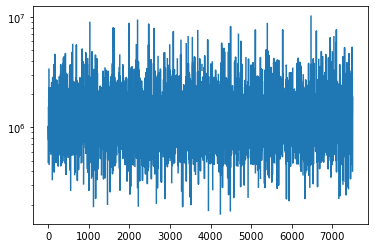

In [9]:
plt.plot(df_train['Annual Income'])
plt.yscale(value="log")

In [10]:
df_train['Years in current job'].unique(), df_test['Years in current job'].unique() 

(array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
        '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
       dtype=object),
 array(['4 years', '1 year', '3 years', '10+ years', '6 years', '5 years',
        '< 1 year', '2 years', '9 years', '8 years', '7 years', nan],
       dtype=object))

In [11]:
is_data_correct(df_train['Tax Liens'])
is_data_correct(df_train['Current Credit Balance'])

[209323.0, 6506797.0, 0.0, 0]

In [12]:
df_train['Current Credit Balance'].quantile(0.8)

412699.0000000001

#### Заполнение пропусков и выбросов простейшими способами

In [13]:
class DataPreprocessing:

# Home Ownership - домовладение
# Annual Income - годовой доход - есть none
# Years in current job - количество лет на текущем месте работы - есть none
# Tax Liens - налоговые обременения
# Number of Open Accounts - количество открытых счетов
# Years of Credit History - количество лет кредитной истории
# Maximum Open Credit - наибольший открытый кредит
# Number of Credit Problems - количество проблем с кредитом
# Months since last delinquent - количество месяцев с последней просрочки платежа - есть none
# Bankruptcies - банкротства - есть none
# Purpose - цель кредита
# Term - срок кредита
# Current Loan Amount - текущая сумма кредита
# Current Credit Balance - текущий кредитный баланс
# Monthly Debt - ежемесячный долг
# Credit Score - ??? - есть none
# Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        
    # Не числовые признаки
        self.binary_to_numbers = {'A': 0, 'B': 1}

    
    def transform(self, X):
        """Трансформация данных"""

#         # Annual Income
        
#         X.loc[X['Annual Income'] == 0, 'Annual Income'] = X['Annual Income'].median()
        
        # Years in current job
        
        # nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
        # '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'
        
        X.loc[X['Years in current job'] == '10+ years', 'Years in current job'] = 11
        X.loc[X['Years in current job'] == '10 years', 'Years in current job'] = 10
        X.loc[X['Years in current job'] == '9 years', 'Years in current job'] = 9
        X.loc[X['Years in current job'] == '8 years', 'Years in current job'] = 8
        X.loc[X['Years in current job'] == '7 years', 'Years in current job'] = 7
        X.loc[X['Years in current job'] == '6 years', 'Years in current job'] = 6
        X.loc[X['Years in current job'] == '5 years', 'Years in current job'] = 5
        X.loc[X['Years in current job'] == '4 years', 'Years in current job'] = 4
        X.loc[X['Years in current job'] == '3 years', 'Years in current job'] = 3
        X.loc[X['Years in current job'] == '2 years', 'Years in current job'] = 2
        X.loc[X['Years in current job'] == '1 year', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = 0
        
        # Current Credit Balance
        
        X.loc[X['Current Credit Balance'] < X['Current Credit Balance'].quantile(.675), 'Current Credit Balance'] = X['Current Credit Balance'].median()
        
        
#         # Months since last delinquent
        
#         X.loc[X['Months since last delinquent'] == 0, 'Months since last delinquent'] = X['Months since last delinquent'].median()
        
#         # Bankruptcies

#         X.loc[X['Annual Income'] == 0, 'Annual Income'] = X['Annual Income'].median()
        
        
        X.fillna(self.medians, inplace=True)
        
        new_num_features(X, 'Purpose')
        new_num_features(X, 'Term')
        new_num_features(X, 'Home Ownership')

        return X

In [14]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_train)

df_train = preprocessor.transform(df_train)
df_test = preprocessor.transform(df_test)
df_train['Years in current job'].fillna(df_train['Years in current job'].median(), inplace=True)
df_test['Years in current job'].fillna(df_test['Years in current job'].median(), inplace=True)
df_train.shape, df_test.shape

((7500, 20), (2500, 19))

In [15]:
df_train.isna().sum(), df_test.isna().sum()

(Home Ownership                  0
 Annual Income                   0
 Years in current job            0
 Tax Liens                       0
 Number of Open Accounts         0
 Years of Credit History         0
 Maximum Open Credit             0
 Number of Credit Problems       0
 Months since last delinquent    0
 Bankruptcies                    0
 Purpose                         0
 Term                            0
 Current Loan Amount             0
 Current Credit Balance          0
 Monthly Debt                    0
 Credit Score                    0
 Credit Default                  0
 Purpose_num                     0
 Term_num                        0
 Home Ownership_num              0
 dtype: int64,
 Home Ownership                  0
 Annual Income                   0
 Years in current job            0
 Tax Liens                       0
 Number of Open Accounts         0
 Years of Credit History         0
 Maximum Open Credit             0
 Number of Credit Problems       0
 Mont

In [16]:
df_train[df_train['Credit Default'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Purpose_num,Term_num,Home Ownership_num
1,Own Home,1025487.0,11.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,1,0
5,Rent,1168386.0,7.0,0.0,12.0,14.6,366784.0,0.0,32.0,0.0,other,Long Term,337304.0,209323.0,18692.0,731.0,1,1,1,2
7,Rent,1040060.0,11.0,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,209323.0,19761.0,705.0,1,1,0,2
9,Home Mortgage,1168386.0,1.0,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,209323.0,17613.0,731.0,1,0,1,1
13,Rent,2066364.0,11.0,0.0,11.0,17.7,1654026.0,0.0,32.0,0.0,debt consolidation,Long Term,549780.0,1037077.0,21869.0,728.0,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,Home Mortgage,1542952.0,11.0,0.0,7.0,12.5,232364.0,0.0,59.0,0.0,debt consolidation,Long Term,267982.0,209323.0,15430.0,695.0,1,0,1,1
7489,Home Mortgage,1394942.0,11.0,0.0,15.0,27.2,1441396.0,0.0,35.0,0.0,debt consolidation,Short Term,753764.0,496698.0,16972.0,742.0,1,0,0,1
7490,Own Home,1368000.0,11.0,0.0,20.0,26.7,897842.0,0.0,69.0,0.0,debt consolidation,Short Term,683650.0,517199.0,29868.0,688.0,1,0,0,0
7493,Rent,1257610.0,8.0,0.0,14.0,16.5,821480.0,0.0,58.0,0.0,debt consolidation,Long Term,448052.0,209323.0,27562.0,676.0,1,0,1,2


In [17]:
feature_names = ['Home Ownership_num',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Purpose_num',
 'Term_num',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']
target_name = 'Credit Default'

In [18]:
X = df_train[feature_names]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

#### Обучение простейшей модели (k ближайших соседей) и вычисление метрики качества

In [19]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_train_pred = neigh.predict(X_train)
y_test_pred = neigh.predict(X_test)

In [20]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3611
           1       0.71      0.56      0.63      1414

    accuracy                           0.81      5025
   macro avg       0.77      0.74      0.75      5025
weighted avg       0.80      0.81      0.80      5025

TEST

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1776
           1       0.34      0.27      0.30       699

    accuracy                           0.64      2475
   macro avg       0.54      0.53      0.53      2475
weighted avg       0.62      0.64      0.63      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1408  368
1                512  187


### EDA

##### Корреляция с целевой переменной:

Text(0.5, 1.0, 'Correlation with target variable')

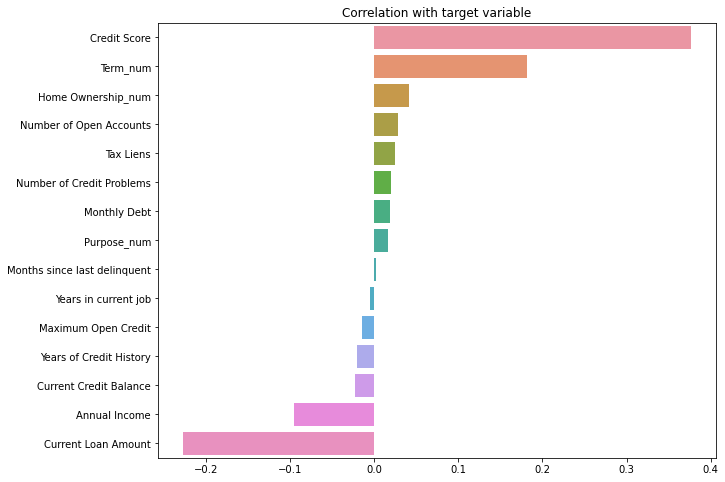

In [21]:
corr_with_target = df_train[feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')

##### Матрица корреляций

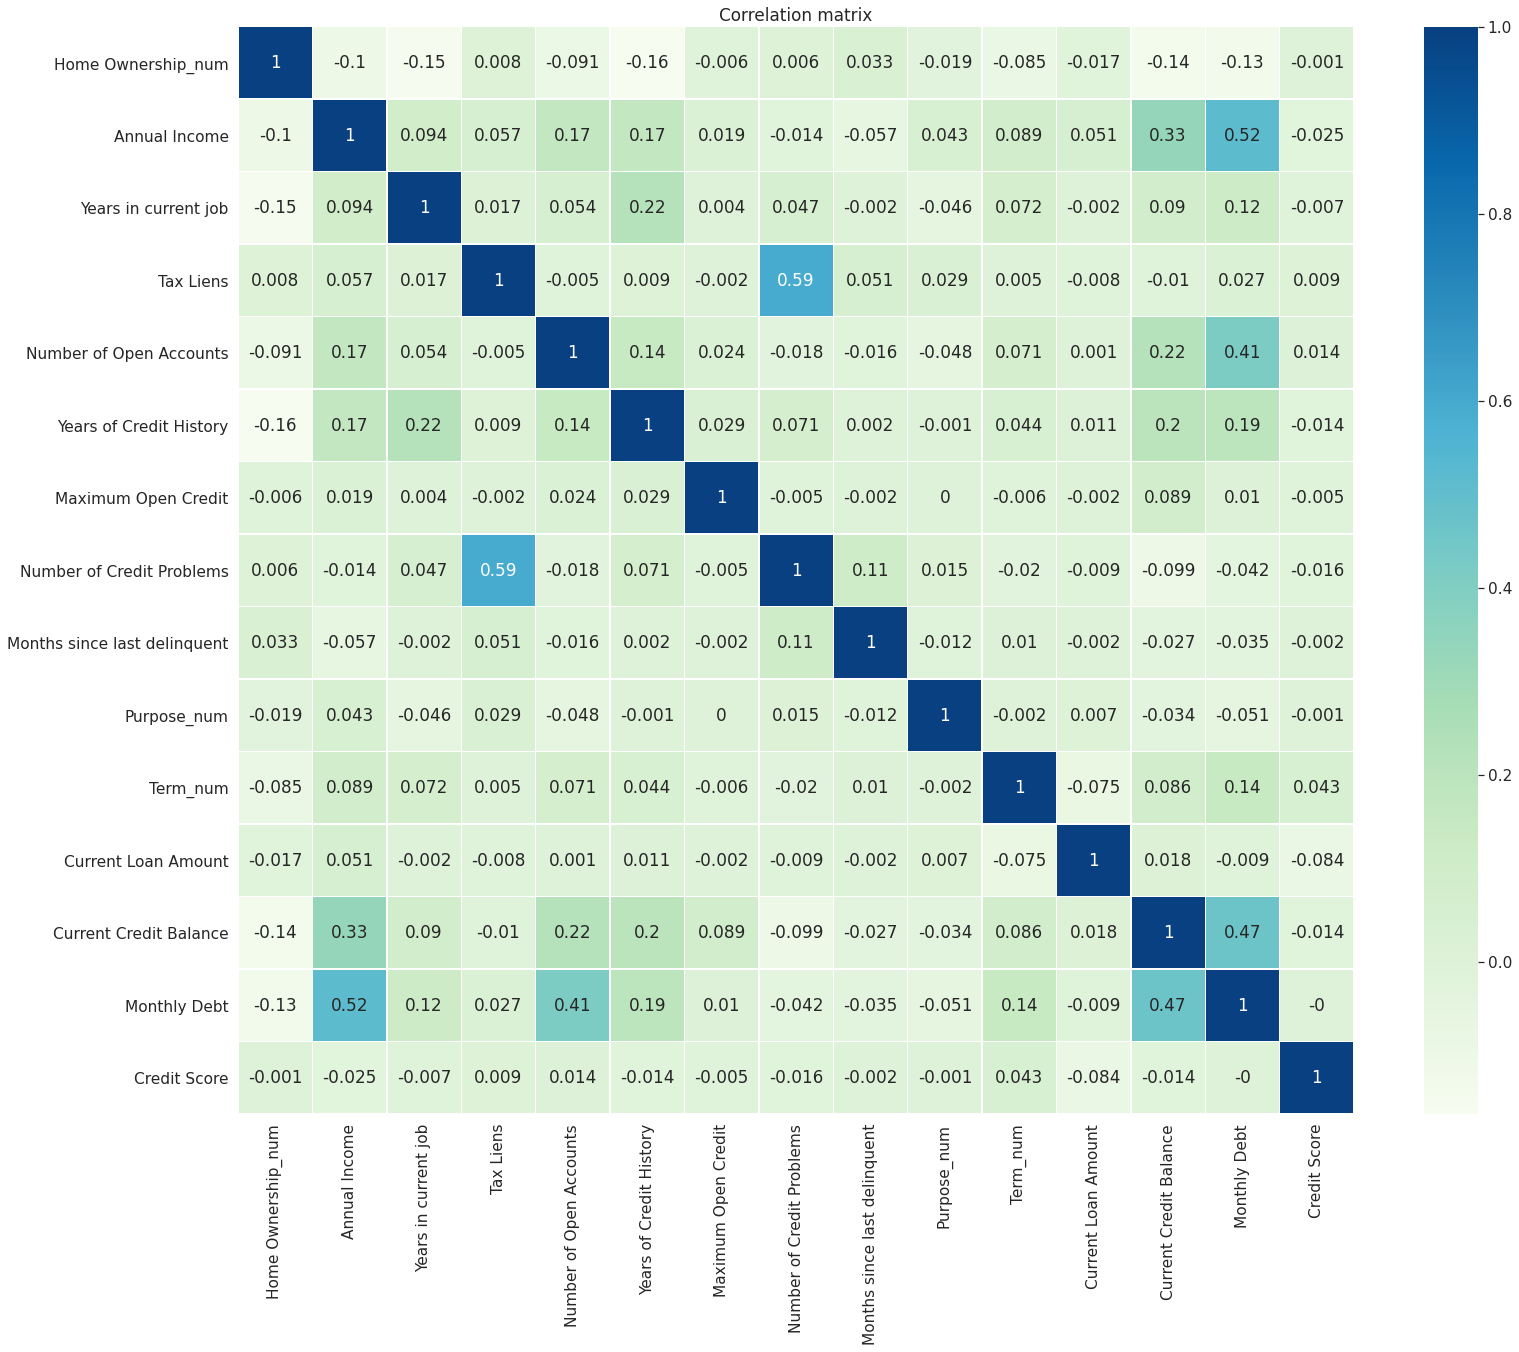

In [22]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[feature_names].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [23]:
class FeatureGenetator():
    """Генерация новых фич"""
    
#  'Home Ownership_num',
#  'Annual Income',
#  'Years in current job',
#  'Tax Liens',
#  'Number of Open Accounts',
#  'Years of Credit History',
#  'Maximum Open Credit',
#  'Number of Credit Problems',
#  'Months since last delinquent',
#  'Purpose_num',
#  'Term_num',
#  'Current Loan Amount',
#  'Current Credit Balance',
#  'Monthly Debt',
#  'Credit Score'
    
    def __init__(self):
        self.tax_problemsnum = None
        self.job_credit_history = None
        self.income_max_credit = None
        self.mounth_debt_credit_balance = None
        self.years_and_number_credits = None
        
        self.max_credit_max = None
        self.max_credit_min = None
        self.max_credit_mean = None
        self.income_max = None
        self.income_min = None
        self.income_mean = None
        self.debt_max = None
        self.debt_mean = None
        self.debt_min = None
        self.balance_max = None
        self.balance_mean = None
        self.balance_min = None
        self.job_years_max = None
        self.job_years_mean = None
        self.job_years_min = None
        self.credit_num_max = None
        self.credit_num_mean = None
        self.credit_num_min = None
        self.credit_years_max = None
        self.credit_years_mean = None
        self.credit_years_min = None
        self.loan_amount_min = None
        self.loan_amount_mean = None
        self.loan_amount_max = None
    
    def fit(self, X, y=None):
        
        X = X.copy()
        
    ##tax, num of credit problems
        if y is not None:
            X['Credit Default'] = y.values
            self.tax_problemsnum = X.groupby(['Tax Liens', 'Number of Credit Problems'], as_index=False).agg({'Credit Default': 'median'})\
                                            .rename(columns={'Credit Default': 'Credit Default by TaxAndProblemsNum'})
            self.tax_problemsnum_median = self.tax_problemsnum['Credit Default by TaxAndProblemsNum'].median()
    
    ##'Years in current job', 'Years of Credit History' cat
        if y is not None:
            self.credit_years_max = X['Years of Credit History'].max()
            self.credit_years_mean = X['Years of Credit History'].mean()
            self.credit_years_min = X['Years of Credit History'].min()
            self.job_years_max = X['Years in current job'].max()
            self.job_years_mean = X['Years in current job'].mean()
            self.job_years_min = X['Years in current job'].min()
            
            X['Credit Default'] = y.values
            X = self.credit_years_to_cat(X)
            X = self.job_years_to_cat(X)
            
            self.job_credit_history_cat = X.groupby(['job_years_cat', 'credit_years_cat'], as_index=False).agg({'Credit Default': 'median'})\
                                            .rename(columns={'Credit Default': 'Credit Default by JobAndCreditHistory_cat'})
            self.job_credit_history_cat_median = self.job_credit_history_cat['Credit Default by JobAndCreditHistory_cat'].median()

    ##'Years in current job', 'Years of Credit History'
        if y is not None:            
            X['Credit Default'] = y.values
            
            self.job_credit_history = X.groupby(['Years in current job', 'Years of Credit History'], 
                                                as_index=False).agg({'Credit Default': 'median'})\
                                            .rename(columns={'Credit Default': 'Credit Default by JobAndCreditHistory'})
            self.job_credit_history_median = self.job_credit_history['Credit Default by JobAndCreditHistory'].median()

            
    ## 'Annual Income', 'Maximum Open Credit'
        if y is not None:
            self.max_credit_max = X['Maximum Open Credit'].max()
            self.income_max = X['Annual Income'].max()
            self.max_credit_min = X['Maximum Open Credit'].min()
            self.income_min = X['Annual Income'].min()
            self.max_credit_mean = X['Maximum Open Credit'].mean()
            self.income_mean = X['Annual Income'].mean()
            
            X['Credit Default'] = y.values
            X = self.max_credit_to_cat(X)
            X = self.income_to_cat(X)
            
            self.income_max_credit = X.groupby(['max_credit_cat','income_cat'], as_index=False).agg({'Credit Default': 'median'})\
                                            .rename(columns={'Credit Default': 'Credit Default by IncomeAndMOC'})
            self.income_max_credit_median = self.income_max_credit['Credit Default by IncomeAndMOC'].median()
            
    ## 'Monthly Debt', 'Current Credit Balance'
        if y is not None:
            self.debt_max = X['Monthly Debt'].max()
            self.balance_max = X['Current Credit Balance'].max()
            self.debt_min = X['Monthly Debt'].min()
            self.balance_min = X['Current Credit Balance'].min()
            self.debt_mean = X['Monthly Debt'].mean()
            self.balance_mean = X['Current Credit Balance'].mean()
            
            X['Credit Default'] = y.values
            X = self.debt_to_cat(X)
            X = self.balance_to_cat(X)
            
            self.mounth_debt_credit_balance = X.groupby(['debt_cat', 'balance_cat'], as_index=False).agg({'Credit Default': 'median'})\
                                            .rename(columns={'Credit Default': 'Credit Default by DebtAndBalance'})
            self.mounth_debt_credit_balance_median = self.mounth_debt_credit_balance['Credit Default by DebtAndBalance'].median()
    
    ## 'Years of Credit History', 'Number of Open Accounts'
        if y is not None:
            self.credit_years_max = X['Years of Credit History'].max()
            self.credit_years_mean = X['Years of Credit History'].mean()
            self.credit_years_min = X['Years of Credit History'].min()
            self.credit_num_max = X['Number of Open Accounts'].max()
            self.credit_num_mean = X['Number of Open Accounts'].mean()
            self.credit_num_min = X['Number of Open Accounts'].min()
    
            X['Credit Default'] = y.values
            X = self.job_years_to_cat(X)
            X = self.credit_num_to_cat(X)
        
            self.years_and_number_credits = X.groupby(['credit_years_cat', 'credit_num_cat'], 
                                                      as_index=False).agg({'Credit Default': 'median'})\
                                            .rename(columns={'Credit Default': 'Credit Default by YearsAndNumberCredits'})
            self.years_and_number_credits_median = self.years_and_number_credits['Credit Default by YearsAndNumberCredits'].median()
        
    
    
    def transform(self, X):
        
        self.loan_amount_max = X['Current Loan Amount'].max()
        self.loan_amount_mean = X['Current Loan Amount'].mean()
        self.loan_amount_min = X['Current Loan Amount'].min()    
        
        X = self.max_credit_to_cat(X)                 
        X = self.income_to_cat(X)
        X = self.debt_to_cat(X)
        X = self.balance_to_cat(X)
        X = self.job_years_to_cat(X)
        X = self.credit_years_to_cat(X)
        X = self.credit_num_to_cat(X)
        X = self.loan_amount_to_cat(X)
        
        if self.tax_problemsnum is not None:
            X = X.merge(self.tax_problemsnum, on=['Tax Liens', 'Number of Credit Problems'], how='left')
            X.fillna(self.tax_problemsnum_median, inplace=True)
        
        if self.job_credit_history_cat is not None:
            X = X.merge(self.job_credit_history_cat, on=['job_years_cat', 'credit_years_cat'], how='left')
            X.fillna(self.job_credit_history_cat_median, inplace=True)
        
        if self.job_credit_history is not None:
            X = X.merge(self.job_credit_history, on=['Years in current job', 'Years of Credit History'], how='left')
            X.fillna(self.job_credit_history_median, inplace=True)
        
        if self.income_max_credit is not None:
            
            X = X.merge(self.income_max_credit, on=['max_credit_cat','income_cat'], how='left')
            X.fillna(self.income_max_credit_median, inplace=True)
            
        if self.mounth_debt_credit_balance is not None:
            X = X.merge(self.mounth_debt_credit_balance, on=['debt_cat', 'balance_cat'], how='left')
            X.fillna(self.mounth_debt_credit_balance_median, inplace=True)

        if self.years_and_number_credits is not None:
            X = X.merge(self.years_and_number_credits, on=['credit_years_cat', 'credit_num_cat'], how='left')
            X.fillna(self.years_and_number_credits_median, inplace=True)        
        
        return X
    
    def income_to_cat(self, X):
        bins = [self.income_min, X['Annual Income'].quantile(0.45), self.income_mean, 
                X['Annual Income'].quantile(0.95), self.income_max]
        X['income_cat'] = pd.cut(X['Annual Income'], bins=bins, labels=False)
        X['income_cat'].fillna(-1, inplace=True) 
        return X
    
    def max_credit_to_cat(self, X):
        bins = [self.max_credit_min, X['Maximum Open Credit'].quantile(0.45), self.max_credit_mean, 
                 X['Maximum Open Credit'].quantile(0.95), self.max_credit_max]
        X['max_credit_cat'] = pd.cut(X['Maximum Open Credit'], bins=bins, labels=False)
        X['max_credit_cat'].fillna(-1, inplace=True) 
        return X
    
    def balance_to_cat(self, X):
        bins = [self.balance_min, self.balance_mean, 
                X['Current Credit Balance'].quantile(0.95), self.balance_max]
        X['balance_cat'] = pd.cut(X['Current Credit Balance'], bins=bins, labels=False)
        X['balance_cat'].fillna(0, inplace=True) 
        return X
    
    def debt_to_cat(self, X):
        bins = [self.debt_min, X['Monthly Debt'].quantile(0.45), self.debt_mean, 
                X['Monthly Debt'].quantile(0.95), self.debt_max]
        X['debt_cat'] = pd.cut(X['Monthly Debt'], bins=bins, labels=False)
        X['debt_cat'].fillna(-1, inplace=True) 
        return X
    
    def credit_years_to_cat(self, X):
        bins = [self.credit_years_min, X['Years of Credit History'].quantile(0.45), self.credit_years_mean, 
                X['Years of Credit History'].quantile(0.95), self.credit_years_max]
        X['credit_years_cat'] = pd.cut(X['Years of Credit History'], bins=bins, labels=False)
        X['credit_years_cat'].fillna(-1, inplace=True) 
        return X
    
    def job_years_to_cat(self, X):
        bins = [self.job_years_min, X['Years in current job'].quantile(0.45), self.job_years_mean, 
                X['Years in current job'].quantile(0.65), self.job_years_max]
        X['job_years_cat'] = pd.cut(X['Years in current job'], bins=bins, labels=False)
        X['job_years_cat'].fillna(-1, inplace=True) 
        return X
    
    def credit_num_to_cat(self, X):
        bins = [self.credit_num_min, X['Number of Open Accounts'].quantile(0.45), self.credit_num_mean, 
                X['Number of Open Accounts'].quantile(0.95), self.credit_num_max]
        X['credit_num_cat'] = pd.cut(X['Number of Open Accounts'], bins=bins, labels=False)
        X['credit_num_cat'].fillna(-1, inplace=True) 
        return X
    
    def loan_amount_to_cat(self, X):
        bins = [self.loan_amount_min, X['Current Loan Amount'].quantile(0.45), self.loan_amount_mean, 
                self.loan_amount_mean * 2, self.loan_amount_max]
        X['loan_amount_cat'] = pd.cut(X['Current Loan Amount'], bins=bins, labels=False)
        X['loan_amount_cat'].fillna(-1, inplace=True) 
        return X    

In [24]:
df_train[df_train['Current Loan Amount'] == 99999999.0]


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Purpose_num,Term_num,Home Ownership_num
0,Own Home,482087.0,6.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,99999999.0,209323.0,7914.0,749.0,0,0,0,0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,0,0,1
6,Home Mortgage,1511108.0,11.0,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,209323.0,2317.0,745.0,0,2,0,1
22,Rent,463790.0,6.0,0.0,6.0,28.3,288442.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,209323.0,5063.0,738.0,0,0,0,2
27,Rent,1004055.0,8.0,0.0,7.0,14.5,328394.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,209323.0,6041.0,734.0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,Rent,1406836.0,1.0,0.0,12.0,22.6,2383260.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,461054.0,7386.0,747.0,0,0,0,2
7445,Home Mortgage,1564384.0,6.0,0.0,21.0,17.3,1545016.0,0.0,32.0,0.0,other,Long Term,99999999.0,1043442.0,32461.0,728.0,0,1,1,1
7464,Home Mortgage,1159152.0,6.0,0.0,14.0,22.0,389356.0,1.0,77.0,1.0,debt consolidation,Short Term,99999999.0,209323.0,18257.0,737.0,0,0,0,1
7475,Rent,848426.0,11.0,0.0,8.0,20.1,526306.0,0.0,12.0,0.0,debt consolidation,Short Term,99999999.0,209323.0,16473.0,742.0,0,0,0,2


In [25]:
features_gen = FeatureGenetator()
features_gen.fit(df_train.drop(columns='Credit Default'), df_train['Credit Default'])

df_train = features_gen.transform(df_train)
df_test = features_gen.transform(df_test)
df_train.shape, df_test.shape

feature_names = ['Home Ownership_num',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Purpose_num',
 'Term_num',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

# feature_names = ['Home Ownership_num',
#  'Annual Income',
#  'Years in current job',
#  'Tax Liens',
#  'Number of Open Accounts',
#  'Years of Credit History',
#  'Maximum Open Credit',
#  'Number of Credit Problems',
#  'Months since last delinquent',
#  'Purpose_num',
#  'Term_num',
#  'Current Loan Amount',
#  'Current Credit Balance',
#  'Monthly Debt',
#  'Credit Score']

target_name = 'Credit Default'

# new_feature_names = ['Credit Default by TaxAndProblemsNum', 
#                      'Credit Default by JobAndCreditHistory', 
#                      'Credit Default by JobAndCreditHistory_cat',
#                      'Credit Default by IncomeAndMOC',
#                      'Credit Default by DebtAndBalance', 
#                      'Credit Default by YearsAndNumberCredits', 
#                      'income_cat',
#                      'max_credit_cat', 
#                      'balance_cat', 
#                      'debt_cat', 
#                      'job_years_cat', 
#                      'credit_years_cat', 
#                      'credit_num_cat']


# Credit Default by JobAndCreditHistory_cat        
# Credit Default by IncomeAndMOC                   
# Credit Default by DebtAndBalance                 
# Credit Default by YearsAndNumberCredits

new_feature_names = ['Credit Default by TaxAndProblemsNum', 
                     'Credit Default by JobAndCreditHistory', 
                     'income_cat',
                     'max_credit_cat', 
                     'balance_cat', 
                     'debt_cat', 
                     'job_years_cat', 
                     'credit_years_cat', 
                     'credit_num_cat']

In [26]:
scaler = StandardScaler()

df_train_norm = df_train.copy()
df_train_norm[feature_names + new_feature_names] = scaler.fit_transform(df_train_norm[feature_names + new_feature_names])

df_train = df_train_norm.copy()

In [27]:
df_train[feature_names + new_feature_names].mean()

Home Ownership_num                       2.369956e-16
Annual Income                            1.252850e-16
Years in current job                    -7.656098e-17
Tax Liens                               -4.879911e-16
Number of Open Accounts                  8.967641e-17
Years of Credit History                 -1.913728e-16
Maximum Open Credit                     -7.831652e-17
Number of Credit Problems                1.222888e-15
Months since last delinquent             4.859631e-16
Purpose_num                              4.741096e-16
Term_num                                -3.342215e-16
Current Loan Amount                      3.500163e-17
Current Credit Balance                   1.086242e-15
Monthly Debt                             3.841372e-17
Credit Score                             1.671256e-17
Credit Default by TaxAndProblemsNum     -6.674920e-16
Credit Default by JobAndCreditHistory    6.631584e-16
income_cat                              -6.099417e-16
max_credit_cat              

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77f9dd9710>,
      dtype=object)

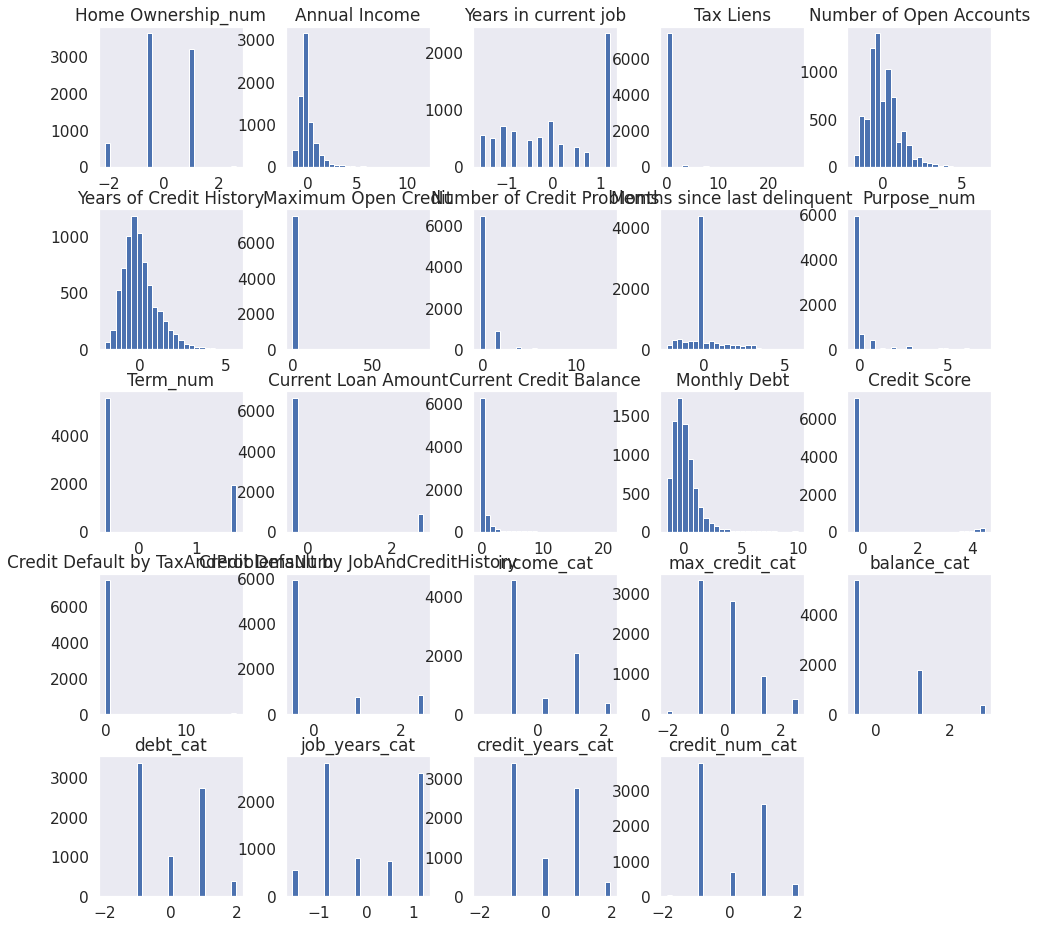

In [28]:
# plt.figure(figsize = (35,30))

df_train[feature_names + new_feature_names].hist(figsize=(16,16), bins=25, grid=False)

In [29]:
credit_sum = df_train['Maximum Open Credit'].mean()
# df_train[df_train['Maximum Open Credit'] == credit_sum]
# df_train['Maximum Open Credit'].quantile(0.75)

# df_train[df_train['Maximum Open Credit'] != 0].plot(figsize=(16,16))

##### Построение моделей

#### XGBoost

In [30]:
X = df_train[feature_names+new_feature_names]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [31]:
model_xgb = xgb.XGBClassifier(random_state=23, 
                              max_depth=2,
                              reg_lambda=185)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)
y_test_pred_probs = model_xgb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3611
           1       0.82      0.55      0.66      1414

    accuracy                           0.84      5025
   macro avg       0.83      0.75      0.77      5025
weighted avg       0.84      0.84      0.83      5025

TEST

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1776
           1       0.79      0.52      0.62       699

    accuracy                           0.82      2475
   macro avg       0.81      0.73      0.76      2475
weighted avg       0.82      0.82      0.81      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1680   96
1                338  361


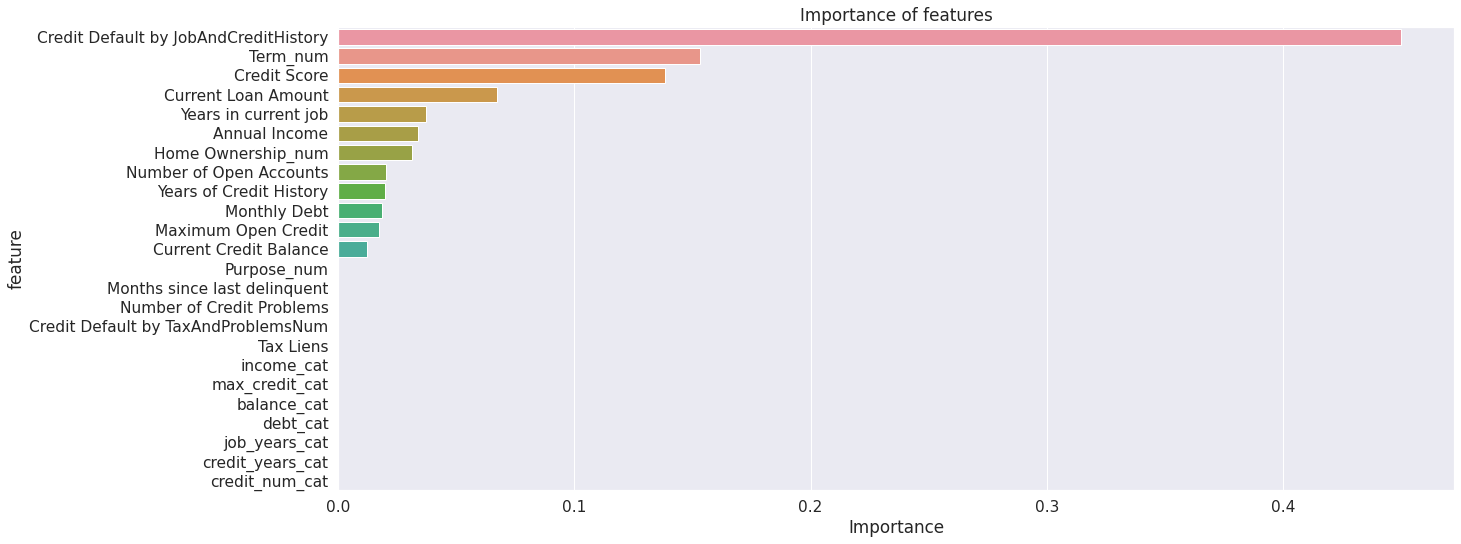

In [32]:
important_features_top = show_feature_importances(X_train.columns, model_xgb.feature_importances_, get_top=17)

In [33]:
important_features_top

['Credit Default by JobAndCreditHistory',
 'Term_num',
 'Credit Score',
 'Current Loan Amount',
 'Years in current job',
 'Annual Income',
 'Home Ownership_num',
 'Number of Open Accounts',
 'Years of Credit History',
 'Monthly Debt',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Purpose_num',
 'Months since last delinquent',
 'Number of Credit Problems',
 'Credit Default by TaxAndProblemsNum',
 'Tax Liens']

In [34]:
X = df_train[important_features_top]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [35]:
model_xgb = xgb.XGBClassifier(n_estimators=10,
                              random_state=23, 
                              max_depth=2,
                              reg_lambda=485)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)
y_test_pred_probs = model_xgb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3611
           1       0.84      0.50      0.63      1414

    accuracy                           0.83      5025
   macro avg       0.84      0.73      0.76      5025
weighted avg       0.84      0.83      0.82      5025

TEST

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1776
           1       0.85      0.48      0.61       699

    accuracy                           0.83      2475
   macro avg       0.84      0.72      0.75      2475
weighted avg       0.83      0.83      0.81      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1716   60
1                365  334


#### LightGBM

In [36]:
model_lgbm = lgbm.LGBMClassifier(n_estimators=10, max_depth=3,
                                      silent=True, random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)
y_test_pred_probs = model_lgbm.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3611
           1       0.88      0.44      0.59      1414

    accuracy                           0.83      5025
   macro avg       0.85      0.71      0.74      5025
weighted avg       0.84      0.83      0.81      5025

TEST

              precision    recall  f1-score   support

           0       0.81      0.97      0.89      1776
           1       0.86      0.43      0.57       699

    accuracy                           0.82      2475
   macro avg       0.84      0.70      0.73      2475
weighted avg       0.83      0.82      0.80      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1728   48
1                401  298


#### CatBoost

In [37]:
# 1500, 5
model_catb = catb.CatBoostClassifier(n_estimators=10, max_depth = 15,
                                     class_weights=[1, 3.5],
                                     silent=True, random_state=21, reg_lambda=85)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.75      0.82      3611
           1       0.55      0.76      0.64      1414

    accuracy                           0.76      5025
   macro avg       0.72      0.76      0.73      5025
weighted avg       0.79      0.76      0.77      5025

TEST

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1776
           1       0.53      0.76      0.63       699

    accuracy                           0.74      2475
   macro avg       0.71      0.75      0.72      2475
weighted avg       0.79      0.74      0.76      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1314  462
1                170  529


##### Выбор лучшей модели

In [38]:
# final_model = catb.CatBoostClassifier(n_estimators=10, max_depth=3,
#                                       class_weights=[1, 3.5],
#                                       silent=True, random_state=5)

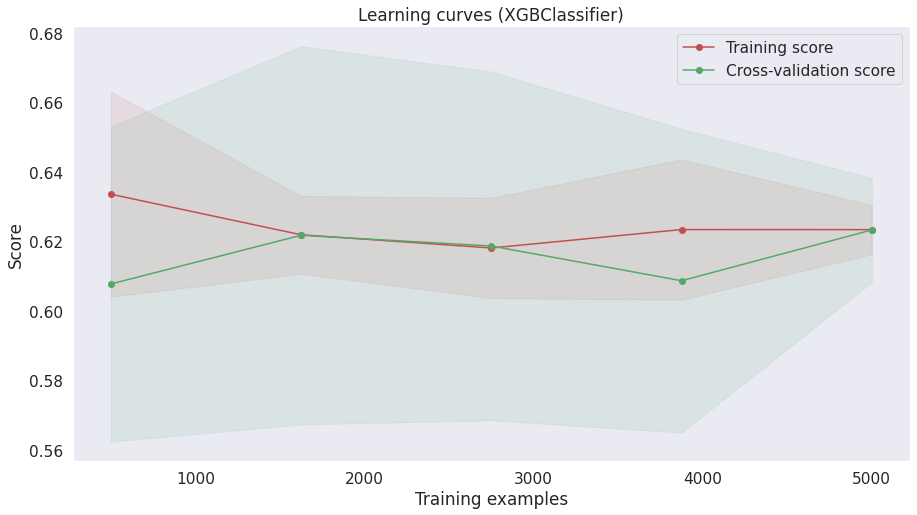

In [39]:
show_learning_curve_plot(model_xgb, X, y)

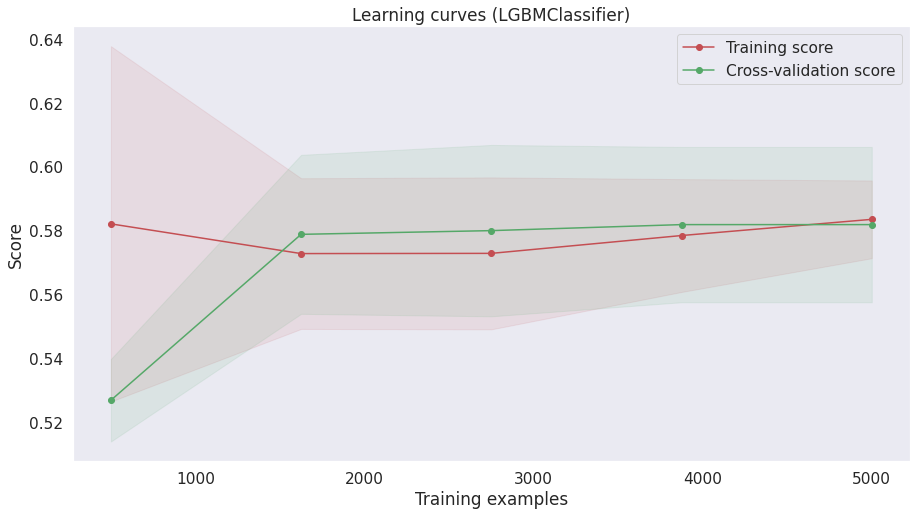

In [40]:
show_learning_curve_plot(model_lgbm, X, y)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


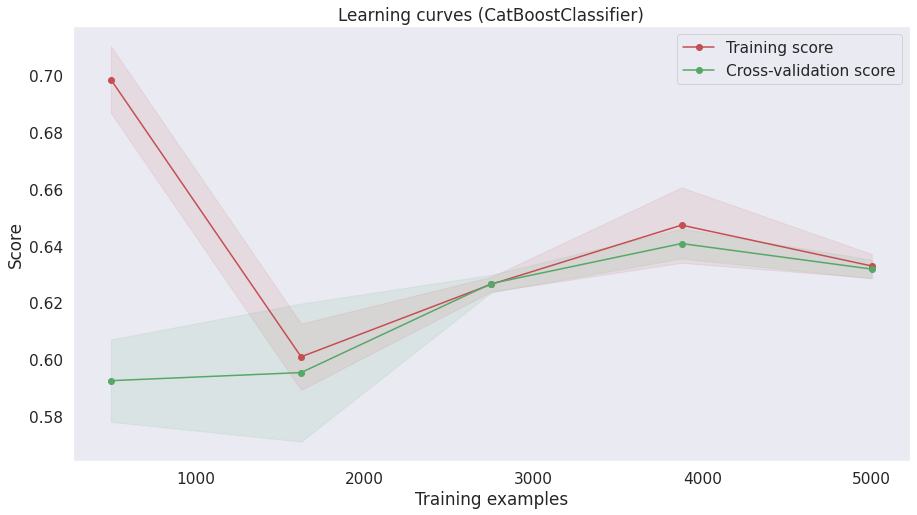

In [41]:
show_learning_curve_plot(model_catb, X, y)

In [42]:
# model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

# params = {'n_estimators':[500, 1500, 2000],
#           'max_depth':[2, 3, 5]}

# cv=KFold(n_splits=3, random_state=21, shuffle=True)

# rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X, y)

# rs.best_score_

In [43]:

#rs.best_params_

In [44]:
#important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [45]:
# final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=2,
#                                       class_weights=[1, 1.5],
#                                       silent=True, random_state=5)
# final_model.fit(X_train[important_features_top], y_train)

# y_train_pred = final_model.predict(X_train[important_features_top])
# y_test_pred = final_model.predict(X_test[important_features_top])
# y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [46]:
final_model = xgb.XGBClassifier(n_estimators=10,
                                random_state=21, 
                                max_depth=2,
                                reg_lambda=485)

final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3611
           1       0.84      0.50      0.63      1414

    accuracy                           0.83      5025
   macro avg       0.84      0.73      0.76      5025
weighted avg       0.84      0.83      0.82      5025

TEST

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1776
           1       0.85      0.48      0.61       699

    accuracy                           0.83      2475
   macro avg       0.84      0.72      0.75      2475
weighted avg       0.83      0.83      0.81      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1716   60
1                365  334


In [47]:
submit = pd.read_csv('../input/geekbrains/sample_submission.csv')
submit

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
2495,2495,1
2496,2496,1
2497,2497,1
2498,2498,1


In [48]:
# from sklearn.ensemble import StackingClassifier
# cls = StackingClassifier([model_xgb, model_lgbm, model_catb])

# cls.fit(X_train,y_train)

# predictions = cls.predict(df_test[feature_names])

# cls.fit(X_train, y_train).score(X_test, y_test)

# submit['Credit Default'] = predictions
# submit.head()

In [49]:
X_train

,Credit Default by JobAndCreditHistory,Term_num,Credit Score,Current Loan Amount,Years in current job,Annual Income,Home Ownership_num,Number of Open Accounts,Years of Credit History,Monthly Debt,Maximum Open Credit,Current Credit Balance,Purpose_num,Months since last delinquent,Number of Credit Problems,Credit Default by TaxAndProblemsNum,Tax Liens
3802,1.019716,-0.591517,-0.232838,2.760520,-1.075563,-0.418311,-0.543147,-0.230398,-0.101892,-0.429018,-0.038508,-0.415167,-0.342427,-2.123888,-0.340979,-0.062849,-0.110953
6500,-0.487551,-0.591517,-0.218932,-0.352987,1.230752,1.205028,1.035156,-0.230398,0.750203,1.653245,0.043347,0.726685,-0.342427,-0.083484,-0.340979,-0.062849,-0.110953
7062,-0.487551,-0.591517,-0.258564,-0.358507,-0.563048,0.203460,-0.543147,-0.026674,-0.428528,-0.637471,-0.021237,0.152289,-0.342427,-0.083484,-0.340979,-0.062849,-0.110953
2926,-0.487551,-0.591517,-0.239096,2.760520,-0.306791,-0.624430,1.035156,0.991947,-1.777676,-0.183000,-0.026771,-0.415167,-0.342427,-0.083484,-0.340979,-0.062849,-0.110953
2635,-0.487551,-0.591517,-0.240487,-0.365231,-1.331820,-0.735988,-0.543147,-1.045295,-1.039195,-1.149630,-0.039278,-0.415167,-0.342427,-0.083484,-0.340979,-0.062849,-0.110953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,1.019716,1.690569,-0.231448,-0.361777,0.461980,-0.207346,-0.543147,0.584498,0.054326,0.561006,-0.043212,-0.415167,0.722775,-0.287525,-0.340979,-0.062849,-0.110953
772,-0.487551,1.690569,-0.231448,-0.356505,1.230752,-0.207346,-0.543147,-0.637847,-0.201302,-0.190044,-0.015637,0.399858,-0.342427,-0.083484,-0.340979,-0.062849,-0.110953
5944,-0.487551,-0.591517,-0.223799,-0.367154,-0.306791,1.374488,-0.543147,0.991947,0.750203,2.434397,0.128672,4.819062,1.787976,-0.083484,-0.340979,-0.062849,-0.110953
5327,-0.487551,1.690569,-0.284290,-0.356414,1.230752,-0.620211,-0.543147,-0.230398,0.522977,-0.447130,-0.028715,0.004150,-0.342427,-0.083484,-0.340979,-0.062849,-0.110953


In [50]:
predictions = final_model.predict(df_test[important_features_top])

submit['Credit Default'] = predictions
#submit[submit['Credit Default'] == 0]
submit

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
2495,2495,1
2496,2496,1
2497,2497,1
2498,2498,1


In [51]:
submit.to_csv('rf_submit.csv', index=False)